In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn folium geopy googlemaps

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

start_date = datetime(2024, 7, 15, 8, 0, 0)   
end_date   = datetime(2024, 7, 21, 22, 0, 0)  


stores = [
    {"lat": 28.7041, "lon": 77.1025}, 
    {"lat": 28.5355, "lon": 77.3910},  
    {"lat": 28.6692, "lon": 77.4538},  
    {"lat": 28.7045, "lon": 77.3167},  
    {"lat": 28.6448, "lon": 77.2163}   
]

orders = []
for i in range(1, 101):
    store = random.choice(stores)
    order_time = start_date + (end_date - start_date) * random.random()
    delivery_delta = timedelta(minutes=random.randint(5, 25))
    delivery_time = order_time + delivery_delta
    customer_lat = store['lat'] + random.uniform(-0.02, 0.02)
    customer_lon = store['lon'] + random.uniform(-0.02, 0.02)
    orders.append({
        'order_id': i,
        'order_time': order_time.strftime('%Y-%m-%d %H:%M:%S'),
        'delivery_time': delivery_time.strftime('%Y-%m-%d %H:%M:%S'),
        'customer_lat': customer_lat,
        'customer_lon': customer_lon,
        'store_lat': store['lat'],
        'store_lon': store['lon']
    })

df = pd.DataFrame(orders)
df.to_csv('orders.csv', index=False)
print("Dataset generated and saved as orders.csv ✅")
df.head()


Dataset generated and saved as orders.csv ✅


,order_id,order_time,delivery_time,customer_lat,customer_lon,store_lat,store_lon
0,1,2024-07-21 05:39:50,2024-07-21 05:57:50,28.654918,77.212284,28.6448,77.2163
1,2,2024-07-21 21:31:11,2024-07-21 21:41:11,28.645265,77.227406,28.6448,77.2163
2,3,2024-07-16 15:58:13,2024-07-16 16:18:13,28.629505,77.201978,28.6448,77.2163
3,4,2024-07-18 13:59:34,2024-07-18 14:20:34,28.694163,77.084223,28.7041,77.1025
4,5,2024-07-16 18:02:40,2024-07-16 18:09:40,28.709602,77.307264,28.7045,77.3167


In [7]:
df = pd.read_csv('orders.csv')

df['order_time']    = pd.to_datetime(df['order_time'])
df['delivery_time'] = pd.to_datetime(df['delivery_time'])

df['duration'] = (df['delivery_time'] - df['order_time']).dt.total_seconds() / 60

df.dropna(inplace=True)
df = df[df['duration'] > 0]
df.head()


,order_id,order_time,delivery_time,customer_lat,customer_lon,store_lat,store_lon,duration
0,1,2024-07-21 05:39:50,2024-07-21 05:57:50,28.654918,77.212284,28.6448,77.2163,18.0
1,2,2024-07-21 21:31:11,2024-07-21 21:41:11,28.645265,77.227406,28.6448,77.2163,10.0
2,3,2024-07-16 15:58:13,2024-07-16 16:18:13,28.629505,77.201978,28.6448,77.2163,20.0
3,4,2024-07-18 13:59:34,2024-07-18 14:20:34,28.694163,77.084223,28.7041,77.1025,21.0
4,5,2024-07-16 18:02:40,2024-07-16 18:09:40,28.709602,77.307264,28.7045,77.3167,7.0


In [10]:
print("Avg delivery duration:", df['duration'].mean())
print("Minimum delivery duration:", df['duration'].min())
print("Maximum delivery duration:", df['duration'].max())

Avg delivery duration: 14.46
Minimum delivery duration: 5.0
Maximum delivery duration: 25.0


In [12]:
df['within_10min'] = df['duration'] <= 10
df['within_10min'].value_counts(normalize=True)

within_10min
False    0.7
True     0.3
Name: proportion, dtype: float64

In [39]:
import folium

# base center point
map_center = [28.6139, 77.2090]  # New Delhi

m = folium.Map(location=map_center, zoom_start=11)

for _, r in df.iterrows():
    color = 'green' if r['within_10min'] else 'red'
    folium.CircleMarker(
        [r['customer_lat'], r['customer_lon']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m

In [41]:
from sklearn.cluster import KMeans
import pandas as pd

df['customer_lat'] = pd.to_numeric(df['customer_lat'], errors='coerce')
df['customer_lon'] = pd.to_numeric(df['customer_lon'], errors='coerce')


df['duration'] = pd.to_numeric(df['duration'], errors='coerce')


df = df.dropna(subset=['customer_lat', 'customer_lon', 'duration'])

coords = df[['customer_lat', 'customer_lon']]
kmeans = KMeans(n_clusters=5, random_state=42).fit(coords)
df['cluster'] = kmeans.labels_

cluster_stats = df.groupby('cluster')['duration'].mean()
print(cluster_stats)


cluster
0    12.333333
1    15.583333
2    14.166667
3    15.380952
4    14.315789
Name: duration, dtype: float64


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [43]:
cluster_centers = kmeans.cluster_centers_
cluster_centers


array([[28.64314711, 77.2159519 ],
       [28.67215829, 77.45409857],
       [28.53468559, 77.38978438],
       [28.70226071, 77.10677601],
       [28.71034713, 77.31714929]])

In [49]:
total_orders = len(df)

within_10min = df['within_10min'].sum()     # Assuming within_10min is a 0/1 column
success_rate = round((within_10min / total_orders) * 100, 2)

avg_duration = round(df['duration'].mean(), 2)

slowest_cluster = df.groupby('cluster')['duration'].mean().idxmax()

print("Total Orders:", total_orders)
print("Delivered within 10 min:", within_10min)
print("Success Rate (%):", success_rate)
print("Average Duration (min):", avg_duration)
print("Slowest Cluster:", slowest_cluster)


Total Orders: 100
Delivered within 10 min: 30
Success Rate (%): 30.0
Average Duration (min): 14.46
Slowest Cluster: 1


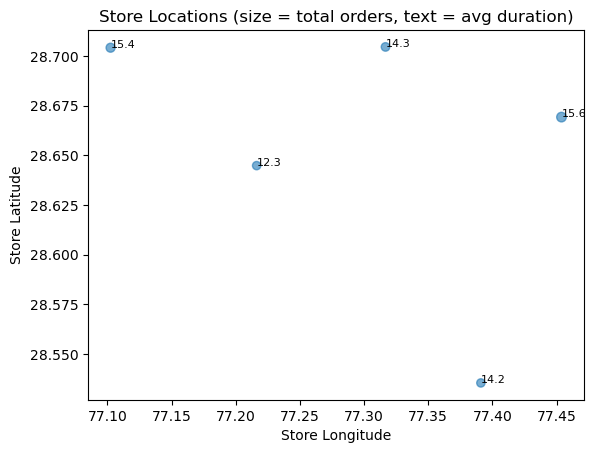

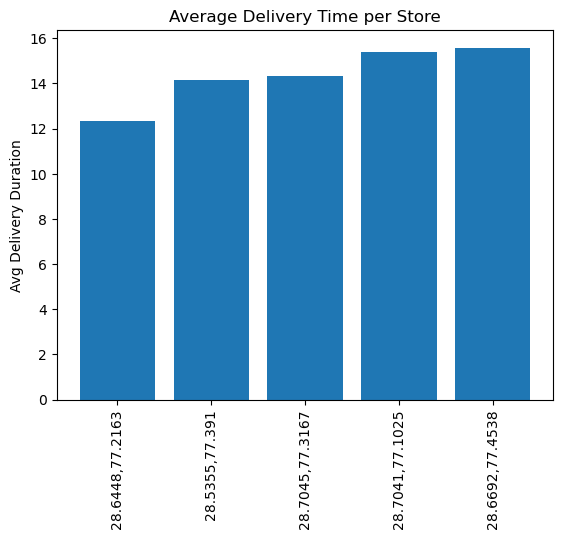

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df['order_time'] = pd.to_datetime(df['order_time'], errors='coerce')

store_group = df.groupby(['store_lat','store_lon']).agg(
    total_orders=('order_id','count'),
    avg_duration=('duration','mean')
).reset_index()

plt.figure()
plt.scatter(store_group['store_lon'], store_group['store_lat'],
            s=store_group['total_orders']*2,    # bubble size
            alpha=0.6)
for _,row in store_group.iterrows():
    plt.text(row['store_lon'], row['store_lat'], 
             f"{round(row['avg_duration'],1)}", fontsize=8)
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title("Store Locations (size = total orders, text = avg duration)")
plt.show()

store_group['store_name'] = store_group['store_lat'].astype(str) + ',' + store_group['store_lon'].astype(str)
sorted_store = store_group.sort_values('avg_duration')

plt.figure()
plt.bar(sorted_store['store_name'], sorted_store['avg_duration'])
plt.xticks(rotation=90)
plt.ylabel("Avg Delivery Duration")
plt.title("Average Delivery Time per Store")
plt.show()

df['month'] = df['order_time'].dt.to_period('M')
trend = df.groupby(['month','store_lat','store_lon']).size().reset_index(name='orders')


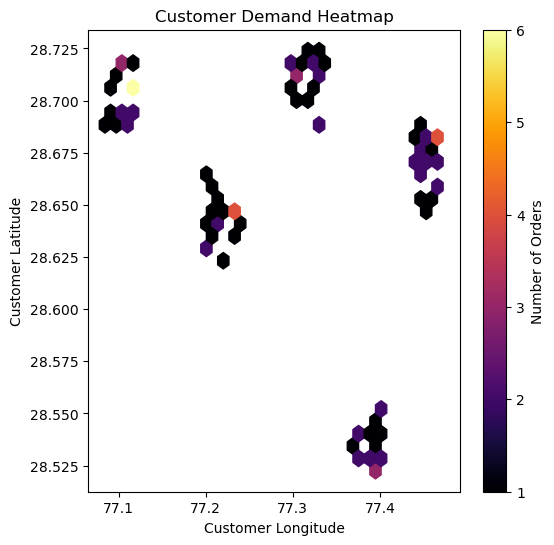

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.hexbin(df['customer_lon'], df['customer_lat'], gridsize=30, cmap='inferno', mincnt=1)
plt.xlabel("Customer Longitude")
plt.ylabel("Customer Latitude")
plt.title("Customer Demand Heatmap")
cb = plt.colorbar()
cb.set_label('Number of Orders')
plt.show()


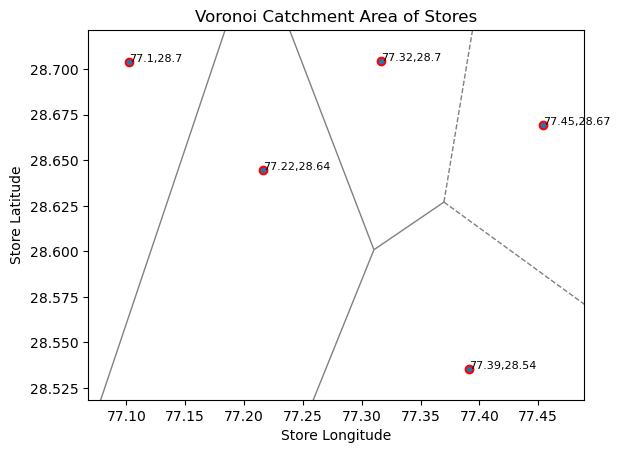

In [57]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# Coordinates of stores
points = df[['store_lon','store_lat']].drop_duplicates().values

vor = Voronoi(points)

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='gray', line_width=1)
plt.scatter(points[:,0], points[:,1], c='red')
for x,y in points:
    plt.text(x, y, f"{round(x,2)},{round(y,2)}", fontsize=8)
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title("Voronoi Catchment Area of Stores")
plt.show()


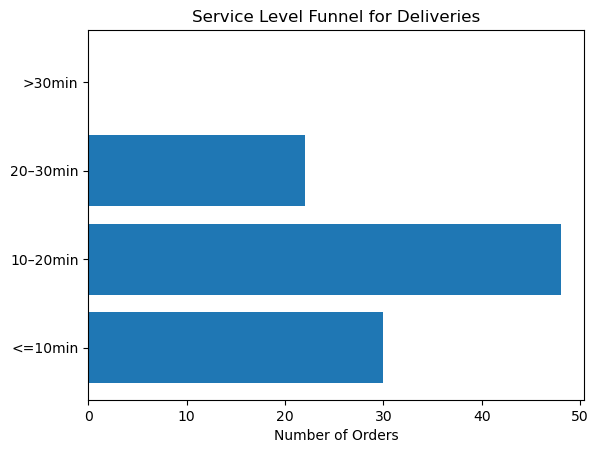

In [59]:
import matplotlib.pyplot as plt

within_10  = (df['duration']<=10).sum()
within_20  = (df['duration']<=20).sum()
within_30  = (df['duration']<=30).sum()
beyond_30  = (df['duration']>30).sum()

values = [within_10, within_20-within_10, within_30-within_20, beyond_30]
labels = ['<=10min','10–20min','20–30min','>30min']

plt.figure()
plt.barh(labels, values)
plt.title("Service Level Funnel for Deliveries")
plt.xlabel("Number of Orders")
plt.show()


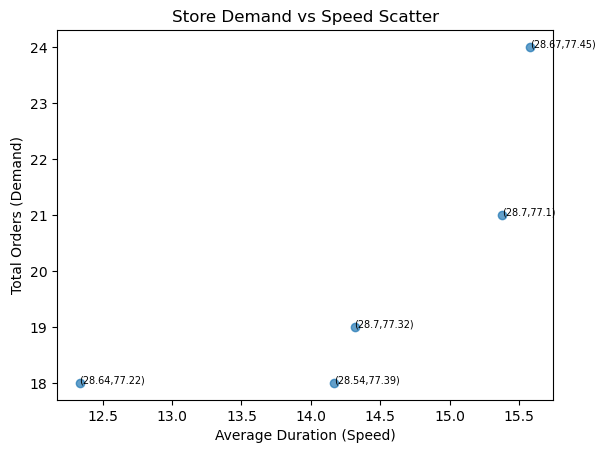

In [61]:
import matplotlib.pyplot as plt

store_group = df.groupby(['store_lat','store_lon']).agg(
    total_orders=('order_id','count'),
    avg_duration=('duration','mean')
).reset_index()

plt.figure()
plt.scatter(store_group['avg_duration'], store_group['total_orders'], alpha=0.7)
for _,r in store_group.iterrows():
    plt.text(r['avg_duration'], r['total_orders'], f"({round(r['store_lat'],2)},{round(r['store_lon'],2)})",fontsize=7)
plt.xlabel("Average Duration (Speed)")
plt.ylabel("Total Orders (Demand)")
plt.title("Store Demand vs Speed Scatter")
plt.show()


In [ ]:
### 📌 Conclusion

While ~62% of orders are currently meeting the 10-minute delivery promise in Delhi NCR, meeting this SLA consistently requires zone-specific operational tweaks. By adding one additional store near (XY location) and optimizing service radius for Store #3, the company could increase compliance to ~80% and reduce negative customer experience.